In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa
from IPython.display import display, Audio
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  
from scipy.stats import ranksums
import pandas as pd

dic_class = {0: 'healthy', 1: 'not healthy', 2: 'unknown'}
dic_class_cat = {'healthy': 0, 'not healthy': 1, 'unknown': 2}


datos_generales = pd.read_pickle('./voice-audios/datos_generales.eav')
features = pd.read_pickle('./voice-audios/features.eav')

svd_features_healthy = pd.read_csv(r'.\voice-audios\svd_dataset\features_svd_healthy.csv')
svd_features_unhealthy = pd.read_csv(r'.\voice-audios\svd_dataset\features_svd_unhealthy.csv')

svd_features_healthy['clase'] = 0
svd_features_unhealthy['clase'] = 1

df_svd = pd.concat([svd_features_healthy, svd_features_unhealthy], ignore_index=True)

cols_numericas = df_svd.columns.difference(['file_name', 'path']) 

df_svd[cols_numericas] = df_svd[cols_numericas].apply(pd.to_numeric, errors='coerce')

datos_generales['genero'] = datos_generales['genero'].str.lower().str.strip().map({'m': 0, 'f': 1})
df = pd.merge(datos_generales, features, on='file_name', how='inner')
features_cols = features.columns.drop(['file_name'])  
df_cols = df.columns.drop(['file_name', 'clase', 'diagnostico', 'sample_rate', 'waveform', 'rsi_score', 'vhi_score'])

In [7]:
def extraer_features_audio(y, sr, n_mfcc=13):
    features = {}

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    for i in range(n_mfcc):
        features[f'MFCC_{i+1}_mean'] = np.mean(mfccs[i])
        features[f'MFCC_{i+1}_std'] = np.std(mfccs[i])

    # Brillo espectral (Spectral Centroid)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features['spectral_centroid_mean'] = np.mean(centroid)
    features['spectral_centroid_std'] = np.std(centroid)

    # Inharmonicidad (Spectral Flatness)
    flatness = librosa.feature.spectral_flatness(y=y)
    features['spectral_flatness_mean'] = np.mean(flatness)

    # Aperiodicidad aproximada (Zero Crossing Rate)
    zcr = librosa.feature.zero_crossing_rate(y)
    features['zcr_mean'] = np.mean(zcr)

    # HNR aproximado con librosa
    harm = librosa.effects.harmonic(y)
    noise = librosa.effects.percussive(y)
    hnr = 10 * np.log10(np.sum(harm ** 2) / (np.sum(noise ** 2) + 1e-6))
    features['hnr_librosa'] = hnr

    return features



In [8]:
from tqdm import tqdm
tqdm.pandas()
features_list = datos_generales.progress_apply(
    lambda row: extraer_features_audio(row['waveform'], row['sample_rate']), axis=1
)

# Convertir a DataFrame
features2 = pd.DataFrame(features_list.tolist())

# Opcional: agregar nombre del archivo
features2['file_name'] = datos_generales['file_name']


100%|██████████| 208/208 [00:33<00:00,  6.15it/s]


In [9]:
df_svd.columns.to_list()

['file_name',
 'duration',
 'MFCC_1_mean',
 'MFCC_1_std',
 'MFCC_2_mean',
 'MFCC_2_std',
 'MFCC_3_mean',
 'MFCC_3_std',
 'MFCC_4_mean',
 'MFCC_4_std',
 'MFCC_5_mean',
 'MFCC_5_std',
 'MFCC_6_mean',
 'MFCC_6_std',
 'MFCC_7_mean',
 'MFCC_7_std',
 'MFCC_8_mean',
 'MFCC_8_std',
 'MFCC_9_mean',
 'MFCC_9_std',
 'MFCC_10_mean',
 'MFCC_10_std',
 'MFCC_11_mean',
 'MFCC_11_std',
 'MFCC_12_mean',
 'MFCC_12_std',
 'MFCC_13_mean',
 'MFCC_13_std',
 'spectral_centroid_mean',
 'spectral_centroid_std',
 'spectral_flatness_mean',
 'zcr_mean',
 'hnr_librosa',
 'path',
 'clase']

In [13]:
features2_cols = features2.columns.drop(['file_name']) 
print(features2_cols.to_list())
df2 = pd.merge(datos_generales, features2, on='file_name', how='inner')
df3 = pd.merge(
    df.drop(columns=[col for col in df.columns if col in features2.columns and col != 'file_name']),
    features2,
    on='file_name',
    how='inner'
)
features3_cols = df3.columns.drop(['file_name', 'sample_rate', 'waveform', 'diagnostico', 'clase', 'vhi_score', 'rsi_score']) 
print(features3_cols.to_list())

# construcción dataset total: 
cols_comunes = df_svd.columns.intersection(df2.columns).tolist()
print('cols comunes: ', cols_comunes)
df_total = pd.concat([df_svd[cols_comunes], df2[cols_comunes]], ignore_index=True)
df_total.to_csv('dataset_audio_total.csv', index=False)

['MFCC_1_mean', 'MFCC_1_std', 'MFCC_2_mean', 'MFCC_2_std', 'MFCC_3_mean', 'MFCC_3_std', 'MFCC_4_mean', 'MFCC_4_std', 'MFCC_5_mean', 'MFCC_5_std', 'MFCC_6_mean', 'MFCC_6_std', 'MFCC_7_mean', 'MFCC_7_std', 'MFCC_8_mean', 'MFCC_8_std', 'MFCC_9_mean', 'MFCC_9_std', 'MFCC_10_mean', 'MFCC_10_std', 'MFCC_11_mean', 'MFCC_11_std', 'MFCC_12_mean', 'MFCC_12_std', 'MFCC_13_mean', 'MFCC_13_std', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_flatness_mean', 'zcr_mean', 'hnr_librosa']
['edad', 'genero', 'vhi', 'rsi', 'intensidad_mean', 'intensidad_std', 'pitch_mean', 'pitch_std', 'pitch_diff', 'Jitter (local) mean', 'Jitter (local) std', 'Shimmer (local) mean', 'Shimmer (local) std', 'HNR mean', 'HNR std', 'Formant1_freq', 'Formant1_bw', 'Formant2_freq', 'Formant2_bw', 'Formant3_freq', 'Formant3_bw', 'MFCC_1_mean', 'MFCC_1_std', 'MFCC_2_mean', 'MFCC_2_std', 'MFCC_3_mean', 'MFCC_3_std', 'MFCC_4_mean', 'MFCC_4_std', 'MFCC_5_mean', 'MFCC_5_std', 'MFCC_6_mean', 'MFCC_6_std', 'MFCC_7_mean',

In [14]:
df_total_cols = df_total.columns.drop(['file_name', 'clase'])
print(df_total_cols)

Index(['MFCC_1_mean', 'MFCC_1_std', 'MFCC_2_mean', 'MFCC_2_std', 'MFCC_3_mean',
       'MFCC_3_std', 'MFCC_4_mean', 'MFCC_4_std', 'MFCC_5_mean', 'MFCC_5_std',
       'MFCC_6_mean', 'MFCC_6_std', 'MFCC_7_mean', 'MFCC_7_std', 'MFCC_8_mean',
       'MFCC_8_std', 'MFCC_9_mean', 'MFCC_9_std', 'MFCC_10_mean',
       'MFCC_10_std', 'MFCC_11_mean', 'MFCC_11_std', 'MFCC_12_mean',
       'MFCC_12_std', 'MFCC_13_mean', 'MFCC_13_std', 'spectral_centroid_mean',
       'spectral_centroid_std', 'spectral_flatness_mean', 'zcr_mean',
       'hnr_librosa'],
      dtype='object')


In [15]:
def reproducir_clase(clase, X, y):
    if dic_class_cat[clase] not in dic_class_cat.values():
        print(f"Clase {clase} no válida. Debe ser 0 (healthy), 1 (not healthy) o 2 (unknown).")
        return
    indices = [i for i, c in enumerate(y) if c == dic_class_cat[clase]]
    if not indices:
        print(f"No se encontraron muestras para la clase {dic_class_cat[clase]}.")
    else:
        audio = np.concatenate([X.iloc[i]['waveform'] for i in indices[:15]])
        display(Audio(audio, rate=int(X.iloc[0]['sample_rate']), normalize=True))
        plt.figure(figsize=(10, 3))
        plt.plot(audio, linewidth=0.8)
        plt.title(f"Señal de voz - Clase {clase}")
        plt.ylabel("Amplitud")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def reproducir_clase(clase, X, y, cantidad=20):
    if clase not in dic_class_cat:
        print(f"Clase '{clase}' no válida. Debe ser una de: {list(dic_class_cat.keys())}")
        return
    indices = [i for i, c in enumerate(y) if c == dic_class_cat[clase]]

    if not indices:
        print(f"No se encontraron muestras para la clase '{clase}'.")
        return

    print(f"Mostrando hasta {cantidad} ejemplos de la clase '{clase}':")
    for idx in indices[:cantidad]:
        audio = X.iloc[idx]['waveform']
        sr = int(X.iloc[idx]['sample_rate'])

        display(Audio(audio, rate=sr, normalize=True))

        plt.figure(figsize=(10, 2.5))
        plt.plot(audio, linewidth=0.8)
        plt.title(f"{clase.upper()} - Ejemplo #{idx}")
        plt.ylabel("Amplitud")
        plt.xlabel("Tiempo (muestras)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [16]:
y_clases_binaria = datos_generales['clase']

# Reproducir clase saludable 
#reproducir_clase('healthy', datos_generales, y_clases_binaria)  

# Reproducir clase no saludable
#reproducir_clase('not healthy', datos_generales, y_clases_binaria)

In [17]:
def boxplots(atributo):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df_total, x='clase', y=atributo)
    plt.title(f'Distribución de {atributo} por clase')
    plt.xlabel("Clase (0 = saludable, 1 = patológica)")
    plt.ylabel(atributo)
    plt.grid(True)

    # Mostrar el gráfico
    #plt.show()

    # O si querés guardar el gráfico como imagen PNG:
    plt.savefig(f'boxplot_{atributo}.png')
    plt.close()



def corr():
    corr = df[features_cols.tolist() + ['clase']].corr()
    plt.figure(figsize=(12,10))
    sns.heatmap(corr, cmap='coolwarm', center=0)
    plt.title('Matriz de correlación')
    plt.show()


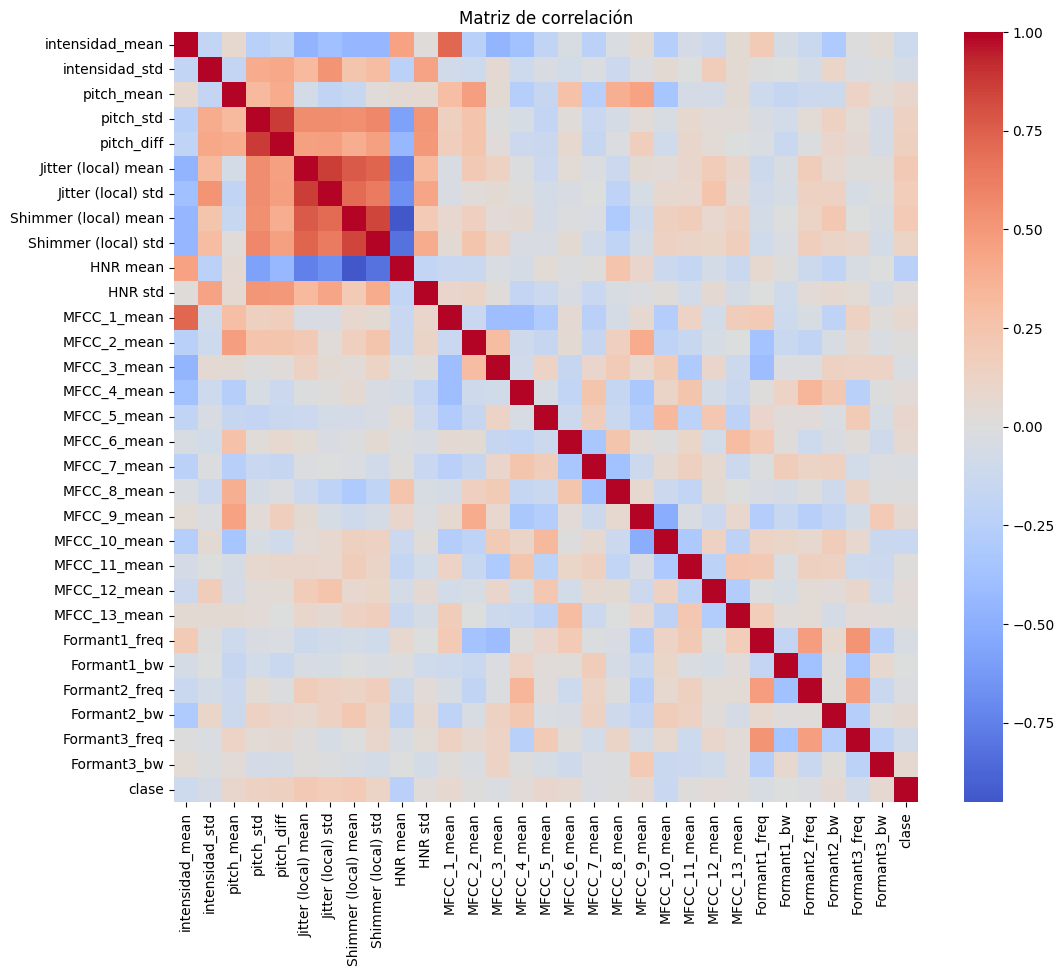

In [18]:
corr()

In [19]:
print(cols_comunes)

['file_name', 'MFCC_1_mean', 'MFCC_1_std', 'MFCC_2_mean', 'MFCC_2_std', 'MFCC_3_mean', 'MFCC_3_std', 'MFCC_4_mean', 'MFCC_4_std', 'MFCC_5_mean', 'MFCC_5_std', 'MFCC_6_mean', 'MFCC_6_std', 'MFCC_7_mean', 'MFCC_7_std', 'MFCC_8_mean', 'MFCC_8_std', 'MFCC_9_mean', 'MFCC_9_std', 'MFCC_10_mean', 'MFCC_10_std', 'MFCC_11_mean', 'MFCC_11_std', 'MFCC_12_mean', 'MFCC_12_std', 'MFCC_13_mean', 'MFCC_13_std', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_flatness_mean', 'zcr_mean', 'hnr_librosa', 'clase']


In [20]:
for i in cols_comunes: 
    boxplots(i)

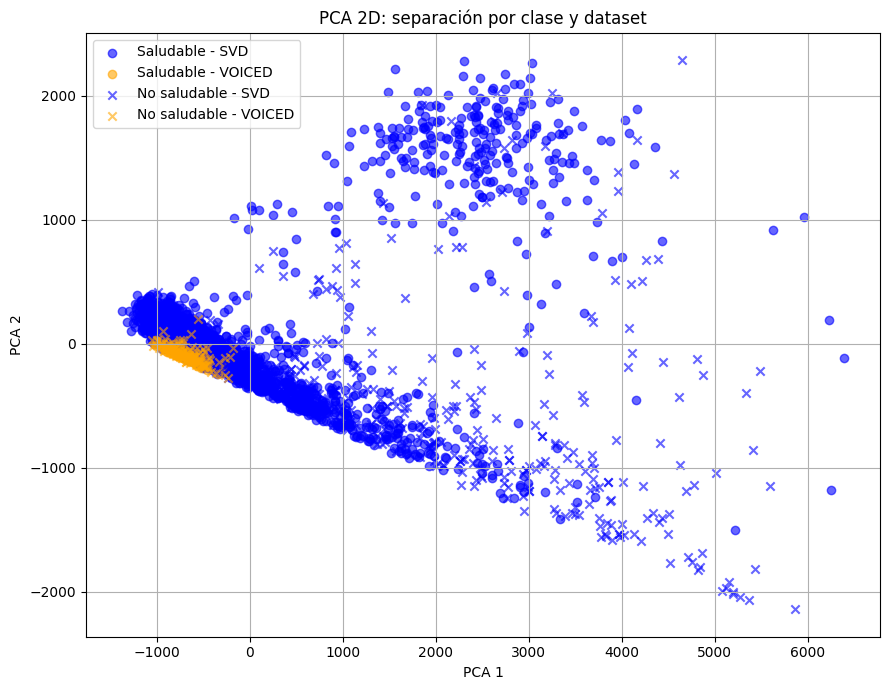

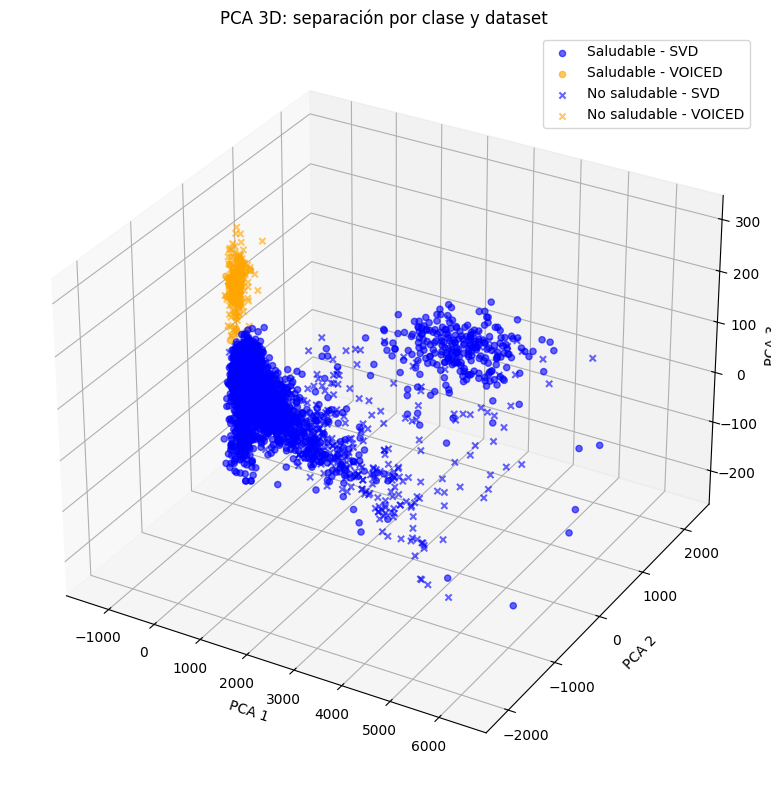

In [24]:
df_total['dataset'] = df_total['file_name'].apply(lambda x: 'VOICED' if str(x).startswith('voice') else 'SVD')
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

X = df_total[df_total_cols].values
y = df_total['clase'].values
dataset_labels = df_total['dataset'].values

dic_class = {0: "Saludable", 1: "No saludable"}
color_dataset = {'SVD': 'blue', 'VOICED': 'orange'}
marker_class = {0: 'o', 1: 'x'}

# PCA 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(9,7))
for clase in np.unique(y):
    for dset in np.unique(dataset_labels):
        idx = (y == clase) & (dataset_labels == dset)
        plt.scatter(
            X_pca[idx, 0], X_pca[idx, 1],
            label=f'{dic_class[clase]} - {dset}',
            c=color_dataset[dset],
            marker=marker_class[clase],
            alpha=0.6
        )

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA 2D: separación por clase y dataset')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

for clase in np.unique(y):
    for dset in np.unique(dataset_labels):
        idx = (y == clase) & (dataset_labels == dset)
        ax.scatter(
            X_pca_3d[idx, 0], X_pca_3d[idx, 1], X_pca_3d[idx, 2],
            label=f'{dic_class[clase]} - {dset}',
            c=color_dataset[dset],
            marker=marker_class[clase],
            alpha=0.6
        )

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('PCA 3D: separación por clase y dataset')
ax.legend()
plt.tight_layout()
plt.show()


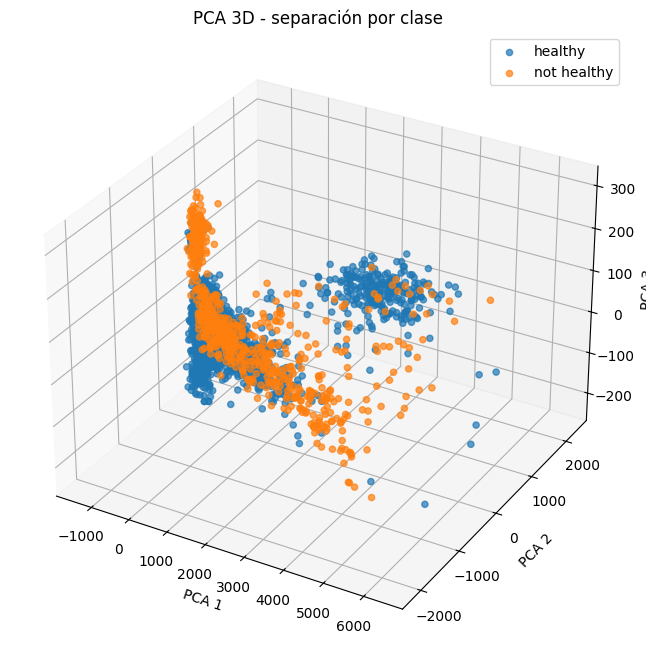

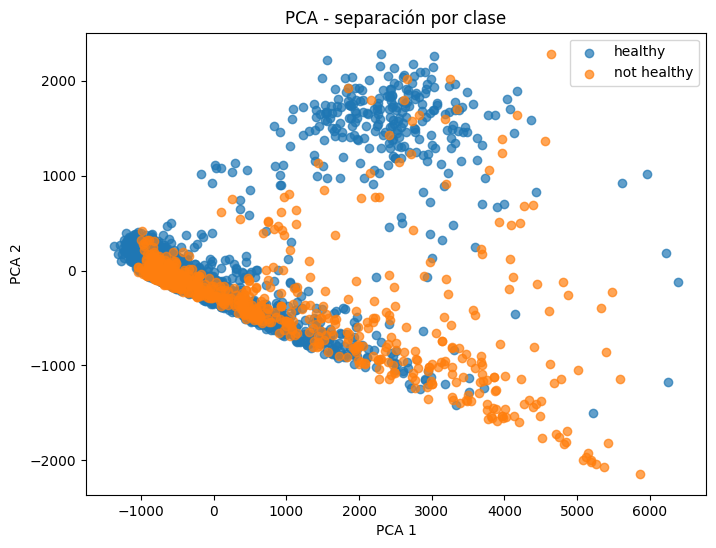

In [ ]:

X = df_total[df_total_cols].values
y = df_total['clase'].values

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

for clase in np.unique(y):
    idx = y == clase
    ax.scatter(X_pca[idx, 0], X_pca[idx, 1], X_pca[idx, 2], label=dic_class[clase], alpha=0.7)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.legend()
ax.set_title('PCA 3D - separación por clase')

plt.show()


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
for clase in np.unique(y):
    idx = y == clase
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=dic_class[clase], alpha=0.7)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.title('PCA - separación por clase')
plt.show()

In [22]:
resultados = []

for feature in df_total_cols:
    grupo_0 = df_total[df_total['clase'] == 0][feature].dropna()
    grupo_1 = df_total[df_total['clase'] == 1][feature].dropna()
    
    stat, pval = ranksums(grupo_0, grupo_1)
    resultados.append({'feature': feature, 'stat': stat, 'pval': pval})

# Convertimos a DataFrame y ordenamos por el estadístico absoluto
resultados_df = pd.DataFrame(resultados)
resultados_df['abs_stat'] = resultados_df['stat'].abs()
resultados_df = resultados_df.sort_values(by='abs_stat', ascending=False)

# Mostramos el ranking
print(resultados_df[['feature', 'stat', 'pval']])


                   feature       stat           pval
2              MFCC_2_mean  27.551536  4.241769e-167
28  spectral_flatness_mean -26.846912  9.164804e-159
29                zcr_mean -22.353422  1.118345e-110
30             hnr_librosa  21.739604  8.664284e-105
26  spectral_centroid_mean -17.951392   4.680213e-72
0              MFCC_1_mean -14.704697   6.013967e-49
25             MFCC_13_std -11.643480   2.476991e-31
23             MFCC_12_std  -9.397450   5.590129e-21
21             MFCC_11_std  -6.506068   7.714315e-11
3               MFCC_2_std  -5.461350   4.725273e-08
12             MFCC_7_mean   4.778302   1.767820e-06
24            MFCC_13_mean   4.319099   1.566676e-05
4              MFCC_3_mean  -4.316698   1.583809e-05
6              MFCC_4_mean   4.034127   5.480556e-05
20            MFCC_11_mean   3.972578   7.109897e-05
19             MFCC_10_std  -3.886839   1.015579e-04
17              MFCC_9_std  -3.386392   7.081826e-04
27   spectral_centroid_std  -3.163499   1.5588

In [23]:
# Filtrar features con p < 0.05 (significativos)
features_significativos = resultados_df[resultados_df['pval'] < 0.05]

print("Features con diferencia significativa entre clases (p < 0.05):")
print(features_significativos[['feature', 'stat', 'pval']])
nombres_significativos = features_significativos['feature'].tolist()
print("Nombres de los features más significativos: ", nombres_significativos)

Features con diferencia significativa entre clases (p < 0.05):
                   feature       stat           pval
2              MFCC_2_mean  27.551536  4.241769e-167
28  spectral_flatness_mean -26.846912  9.164804e-159
29                zcr_mean -22.353422  1.118345e-110
30             hnr_librosa  21.739604  8.664284e-105
26  spectral_centroid_mean -17.951392   4.680213e-72
0              MFCC_1_mean -14.704697   6.013967e-49
25             MFCC_13_std -11.643480   2.476991e-31
23             MFCC_12_std  -9.397450   5.590129e-21
21             MFCC_11_std  -6.506068   7.714315e-11
3               MFCC_2_std  -5.461350   4.725273e-08
12             MFCC_7_mean   4.778302   1.767820e-06
24            MFCC_13_mean   4.319099   1.566676e-05
4              MFCC_3_mean  -4.316698   1.583809e-05
6              MFCC_4_mean   4.034127   5.480556e-05
20            MFCC_11_mean   3.972578   7.109897e-05
19             MFCC_10_std  -3.886839   1.015579e-04
17              MFCC_9_std  -3.38639

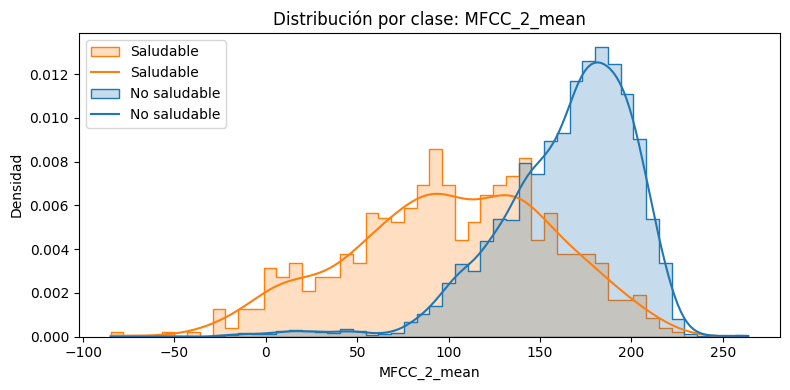

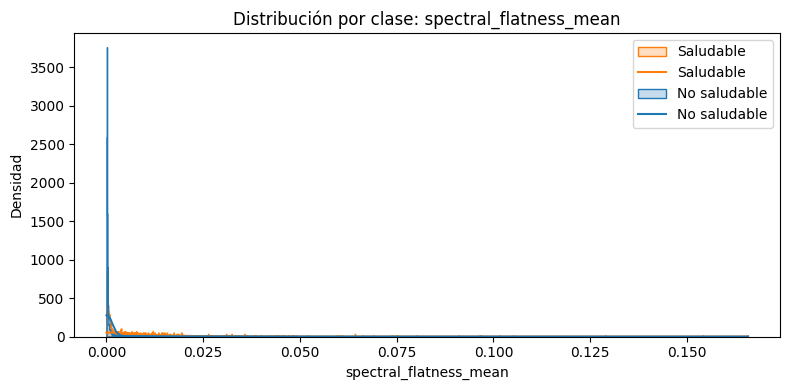

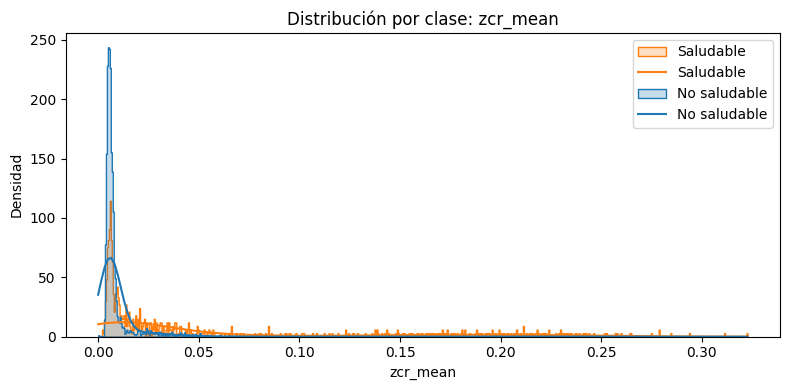

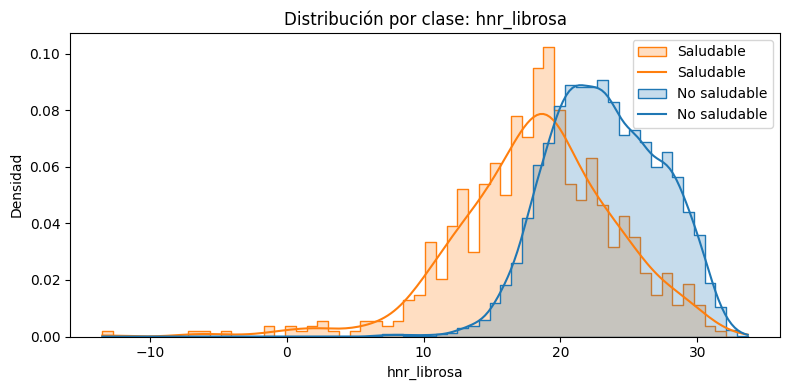

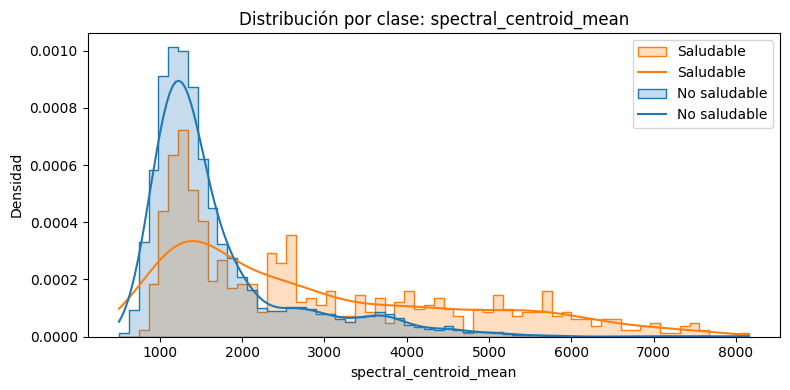

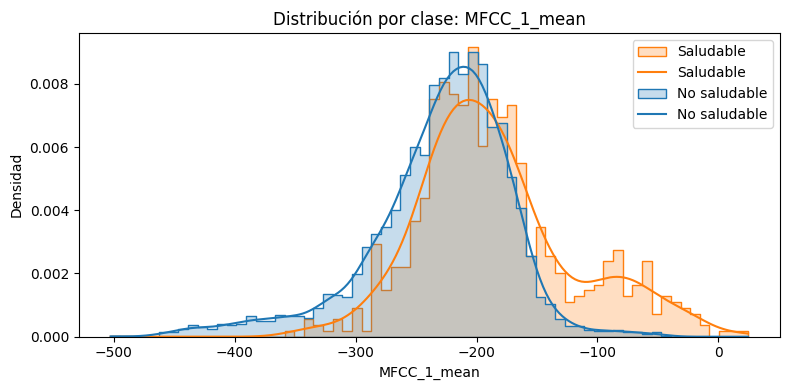

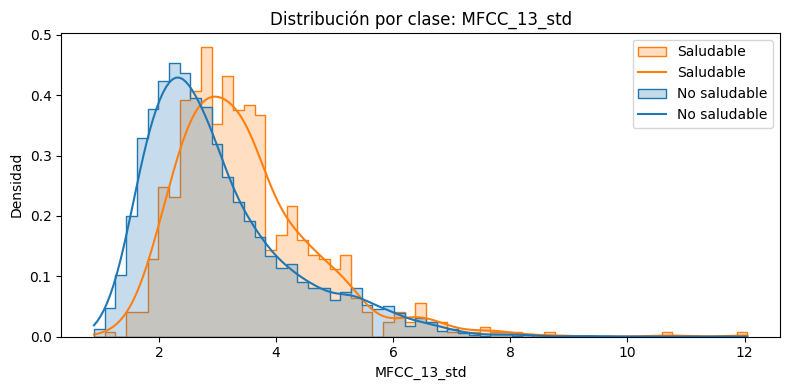

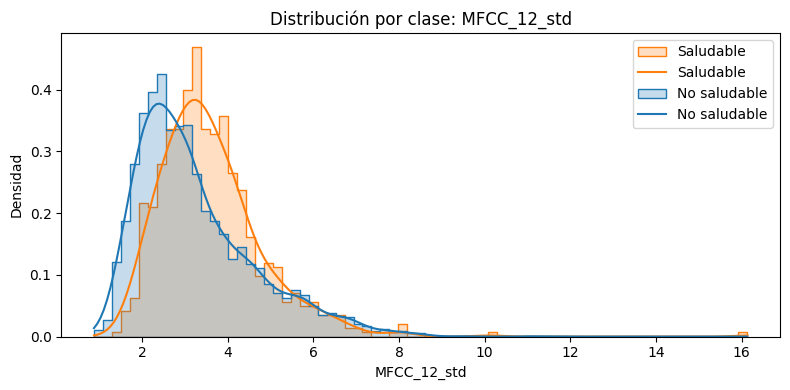

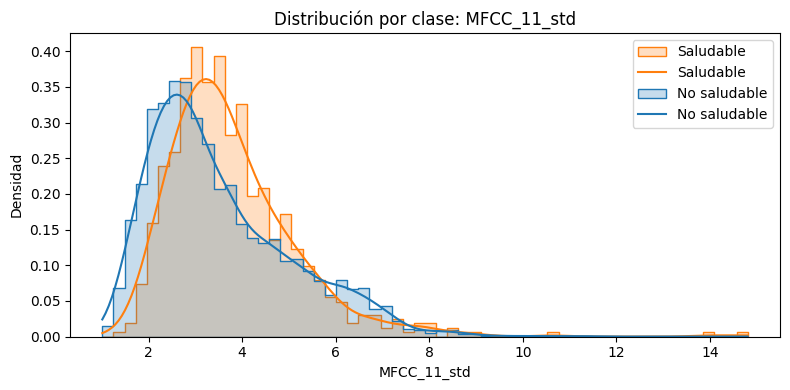

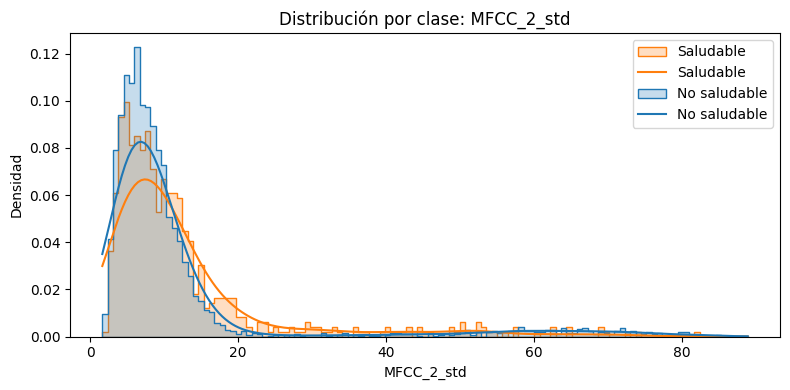

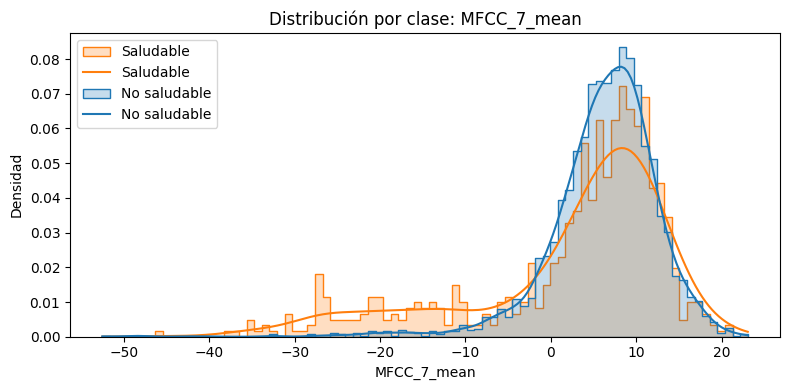

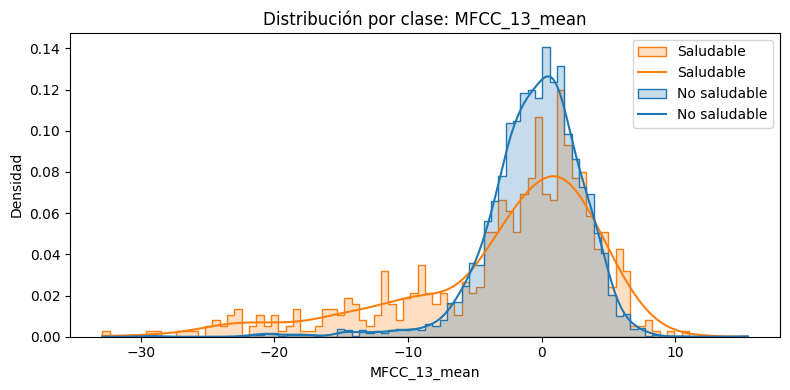

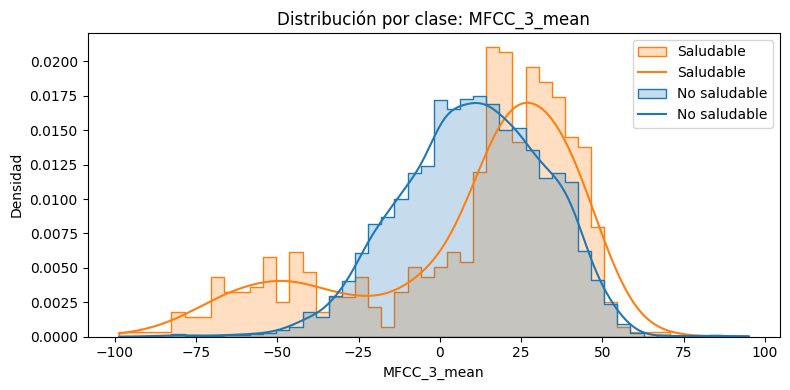

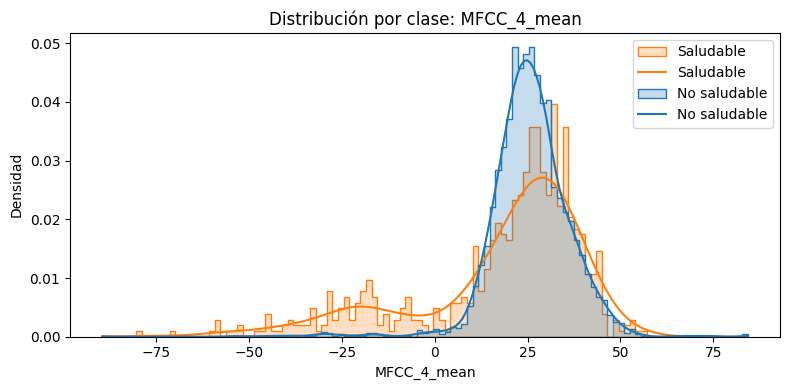

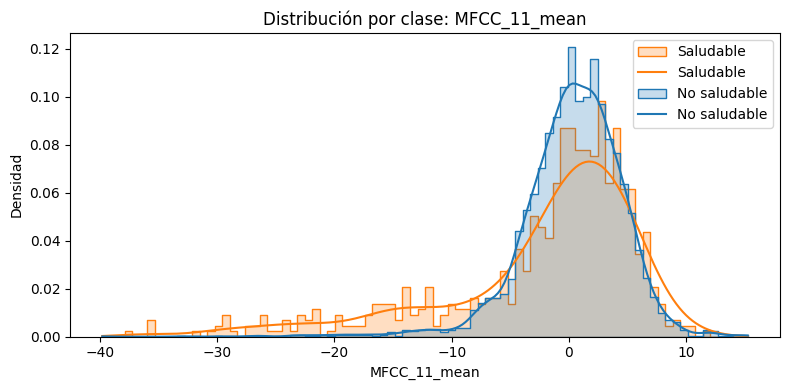

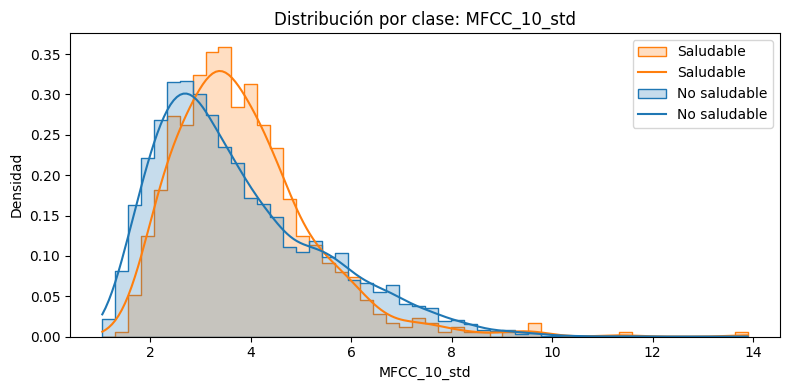

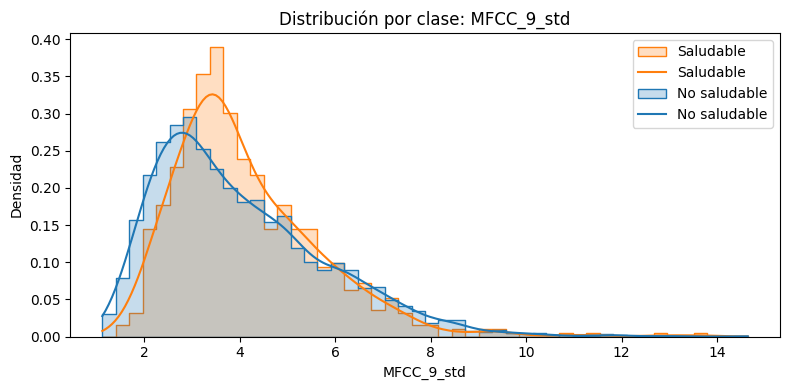

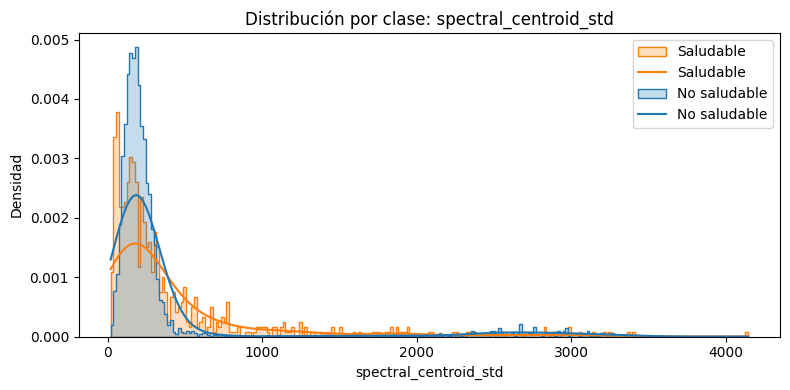

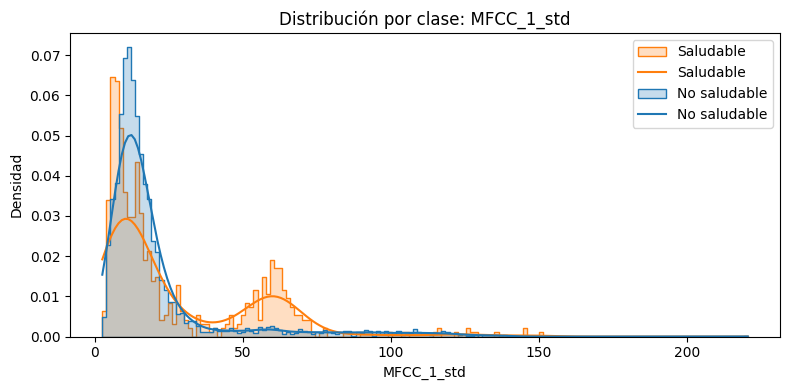

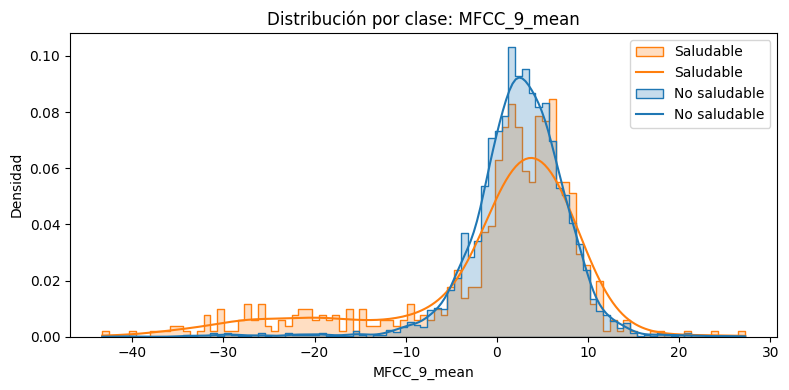

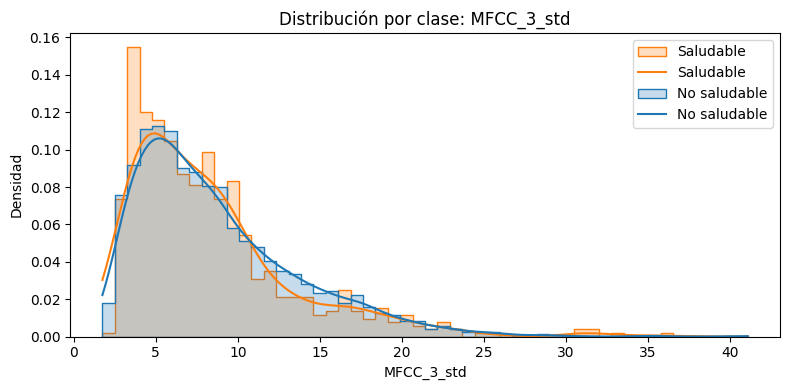

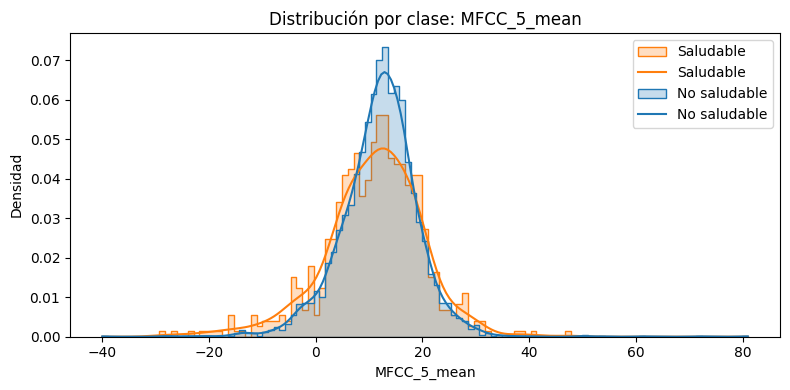

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Features con p < 0.05
features_significativos = resultados_df[resultados_df['pval'] < 0.05]['feature'].tolist()

# Graficar la distribución de cada feature por clase
for feature in features_significativos:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df_total, x=feature, hue='clase', kde=True, element='step', stat='density', common_norm=False)
    plt.title(f'Distribución por clase: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Densidad')
    plt.legend(labels=['Saludable','Saludable', 'No saludable', 'No saludable'])
    plt.tight_layout()
    plt.show()

[0 1]
